In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain_core
    Fo

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [3]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "",
    model_name = "llama-3.3-70b-versatile"
)

In [6]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [7]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

In [8]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

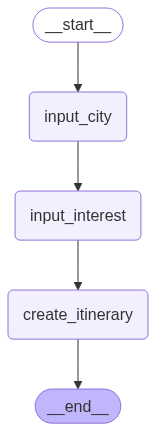

In [9]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [10]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [11]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: Gangtok , Sikkim
Please enter your interest for the trip to : Gangtok , Sikkim (comma-separted): 
Your Input: Waterfalls
Creating an itinerary for Gangtok , Sikkim based on interests : Waterfalls

Final Itinerary: 
Here's a brief, bulleted itinerary for a day trip to Gangtok, Sikkim, focusing on waterfalls:

* 8:00 AM: Start the day with a visit to **Bakthang Waterfall**, a picturesque spot surrounded by lush green forests.
* 10:00 AM: Head to **Himalayan Zoological Park** and stop by the **Tashi View Point** to enjoy the stunning views of the Himalayas.
* 12:30 PM: Visit the **Seven Sisters Waterfall**, a breathtaking spot with seven distinct waterfalls cascading down a rocky cliff.
* 3:00 PM: Stop for lunch and refreshments at a local restaurant.
* 4:30 PM: Explore the **Ban Jhakri Waterfall**, a scenic spot with a beautiful waterfall and a nearby park with statues and 

In [12]:
!pip install gradio

In [14]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.0.1.json: 0.00B [00:00, ?B/s]

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8dcf9a8e3feff94893.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
